In [ ]:
#@title #Clone image-gpt + install dependencies
!git clone https://github.com/maciejbalawejder/igpt &> /dev/null
!pip uninstall -y tensorflow &> /dev/null
!pip install -r igpt/requirements.txt &> /dev/null

In [ ]:
#@title # Load Model
#@markdown Choose all the values first and then run the cell.
# Constants
"""
Args:
    BATCH : the amount of images to generate
    MODEL_SIZE : s, m, l are available
    CROP_N_PX : number of pixels cropped
"""
import matplotlib.pyplot as plt
import PIL 
import numpy as np

BATCH = 4 #@param {type:"slider", min:1, max:8, step:1} 
MODEL_SIZE = 's' #@param ['s', 'm', 'l'] {type:"string"}
N_PX = 32 # Number of pixels
CKPT = 1_000_000 # Checkpoint : 131_000, 262_000, 524_000 are also available. We take the last one.


MODEL_CONFIG = {
    # model configuration : [n_embdedding, n_head, n_layer]
    's' : [512, 8, 24],
    'm' : [1024, 8, 36],
    'l' : [1536, 16, 48]
}
N_EMBD, N_HEAD, N_LAYER = MODEL_CONFIG[MODEL_SIZE]
N_GPU = 1

# Create folders
!mkdir -p /downloads/clusters/
!mkdir -p /downloads/model/
!mkdir results

!python igpt/download.py --model {MODEL_SIZE} --ckpt {CKPT} --download_dir ./downloads/model/ &> /dev/null
!python igpt/download.py --clusters --download_dir ./downloads/clusters/ &> /dev/null

CLUSTERS_PATH = "downloads/clusters/"
MODEL_PATH = "downloads/model/"
CLUSTERS = np.load("{}kmeans_centers.npy".format(CLUSTERS_PATH))

def squared_euclidean_distance(a, b):
    # a -> img shape : [(32*32) -> 1024, 3]
    # b -> clusters shape : [512, 3] 
    b = np.transpose(b)
    a2 = np.sum(np.square(a), axis=1, keepdims=True) # a2 shape : [1024, 1]
    b2 = np.sum(np.square(b), axis=0, keepdims=True) # b2 shape : [512, 1]
    ab = np.matmul(a, b) # ab shape : [1024, 512]
    # (a - b) ** 2 = a**2 - 2ab - b**2
    d = a2 - 2*ab + b2
    # d shape: [1024, 512] -> each pixel in the image has assigned 512 distances to the clusters
    return d

def color_quantize(x, np_clusters):
    x = np.reshape(x, [-1, 3])
    # x -> img shape: [1024, 3]
    d = squared_euclidean_distance(x, CLUSTERS)
    d = np.argmin(d, 1)
    # d shape: [1024,] -> each pixel in the image has assigned index to the cluster with the minimal distance
    return d

def cluster_to_pixel(img):
    # img shape : [H*W, ]
    H, W = len(img) // 32, 32
    pixels = np.rint(127.5 * (CLUSTERS[img] + 1.0)).reshape(H, W, 3)
    return pixels.astype(np.uint8)

def preprocessing(img, primers=False):
    # Make square image
    w, h = img.size
    d_size = min(img.size)
    box = (
        (w - d_size) // 2,
        (h - d_size) // 2,
        w - (w - d_size) // 2,
        h - (h - d_size) // 2 
    )
    # box = (left, upper, right, lower)
    img = img.crop(box)

    # Resize
    img = img.resize((N_PX, N_PX), PIL.Image.LANCZOS)
    img = np.array(img).astype('float32')
    # img shape: [32, 32, 3] with range <0,255>

    # Normalization
    img = img / 127.5 - 1
    # img shape: [32, 32, 3] with range <-1, 1>

    # Convert to 9-bit Colour Palette
    img = color_quantize(img, CLUSTERS)
    # img shape: [32*32 -> (1024),]

    if primers:
        img = img.reshape(N_PX, N_PX)
        img = img[:CROP_N_PX, :].flatten().tolist()
        # img shape : [(N_PX - CROP_N_PX) * N_PX,]

    return img

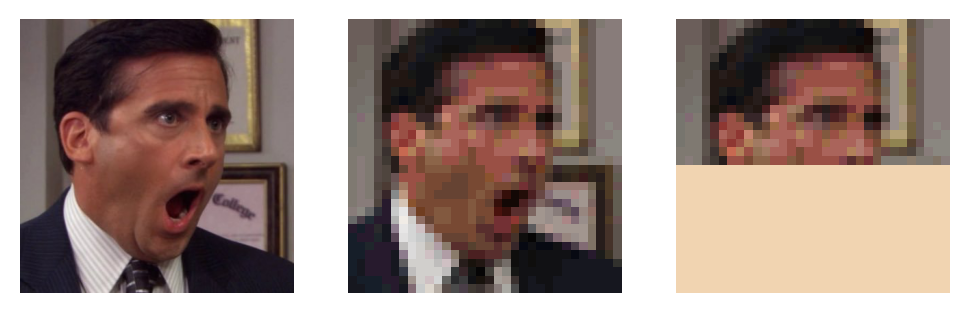

In [ ]:
#@title # Load and Preprocess Image

CROP_N_PX =  15#@param {type:"integer"}
CROP_N_PX = N_PX - CROP_N_PX
IMAGE_NAME = "scott.jpg" #@param {type:"string"}

if IMAGE_NAME != "":
    img = PIL.Image.open("{}".format(IMAGE_NAME))
else:
    if np.random.random() > 0.5:
        img = PIL.Image.open("igpt/test_img/{}".format("blackbird.jpg"))
    else:
        img = PIL.Image.open("igpt/test_img/{}".format("pepe.jpg"))

plt.figure(dpi=200)

plt.subplot(131)
plt.axis("off")
plt.imshow(img)

plt.subplot(132)
plt.axis("off")
pre_img = preprocessing(img, primers=False)
plt.imshow(cluster_to_pixel(pre_img))

plt.subplot(133)
pre_img = preprocessing(img, primers=True)
primers = np.zeros((BATCH, N_PX * N_PX))
batch_img = BATCH * [pre_img]
primers[:, :len(pre_img)] = batch_img 
plt.imshow(cluster_to_pixel(primers[0].astype(np.int64)))
plt.axis("off")

SAVE_IMAGE = False #@param {type:"boolean"}
if SAVE_IMAGE:
    plt.savefig("preprocess_{}.png".format(IMAGE_NAME[:-4]))

{'n_embd': 512, 'n_head': 8, 'n_gpu': 1, 'n_sub_batch': 4, 'sample': True}




trainable parameters: 76571648
INFO:tensorflow:Restoring parameters from downloads/model/model.ckpt-1000000


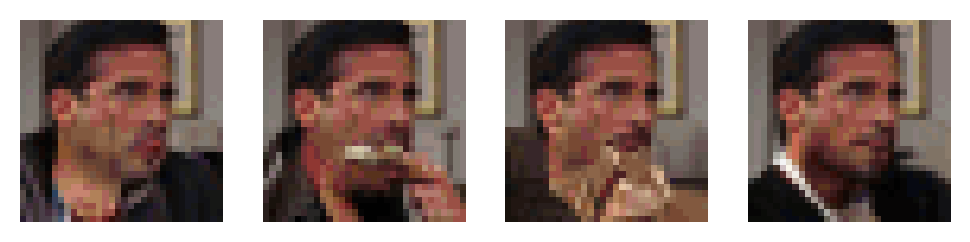

In [ ]:
#@title # Run the cell to generate the Completions
#@markdown All the generated images are in the __results__ folder if you want to run again restart runtime.
from igpt.src.run import main, RunConfig
args = RunConfig()
args.n_embd = N_EMBD
args.n_head = N_HEAD
args.n_gpu = N_GPU
args.n_sub_batch = BATCH
args.sample = True
print(vars(args))
main(args, pre_img)

plt.figure(dpi=200)
for i in range(BATCH):
    r, c = 1, BATCH
    img = plt.imread("results/sample_{}.png".format(i))
    plt.subplot(int(str(r) + str(c) + str(i+1)))
    plt.imshow(img)
    plt.axis("off")

SAVE_RESULTS_PLOT = False #@param {type:"boolean"}
if SAVE_RESULTS_PLOT:
    plt.savefig("results_{}.png".format(IMAGE_NAME[:-4]))